# Car Damage Detection Project

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Transform Image For Training Models Beter

In [6]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Data

In [8]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [9]:
2300*0.75

1725.0

In [10]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [11]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [12]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [14]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [16]:
images[0].shape

torch.Size([3, 224, 224])

In [17]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


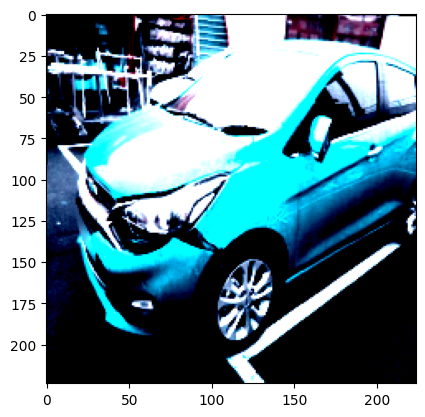

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(images[31].permute(1,2,0))
plt.show()

# Building Model

In [72]:
class CarClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.network = nn.Sequential(
            # ---- Block 1 ----
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # 32 × 224 × 224
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # 32 × 112 × 112

            # ---- Block 2 ----
            nn.Conv2d(32, 40, kernel_size=3, stride=1, padding=1), # 40 × 112 × 112
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=3, stride=1),                 # 40 × 110 × 110

            # ---- Block 3 ----
            nn.Conv2d(40, 64, kernel_size=3, stride=1, padding=1), # 64 × 110 × 110
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),                 # 64 × 55 × 55

            # ---- Block 4 ----
            nn.Conv2d(64, 64, kernel_size=2, stride=1),             # 64 × 54 × 54
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),                 # 64 × 27 × 27

            # ---- Classifier ----
            nn.Flatten(),
            nn.Linear(64 * 27 * 27, 512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)


In [73]:
import time

In [76]:
def training_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

### Start Training 

In [ ]:
model = CarClassifier(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
all_labels, all_predictions = training_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.68
Batch: 20, Epoch: 1, Loss: 1.73
Batch: 30, Epoch: 1, Loss: 1.72
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.48
Epoch [1/10], Avg Loss: 1.6831
*** Validation Accuracy: 44.17% ***
Batch: 10, Epoch: 2, Loss: 1.26
Batch: 20, Epoch: 2, Loss: 1.65
Batch: 30, Epoch: 2, Loss: 1.25
Batch: 40, Epoch: 2, Loss: 0.94
Batch: 50, Epoch: 2, Loss: 1.13
Epoch [2/10], Avg Loss: 1.3344
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 3, Loss: 1.14
Batch: 20, Epoch: 3, Loss: 1.13
Batch: 30, Epoch: 3, Loss: 1.06
Batch: 40, Epoch: 3, Loss: 1.04
Batch: 50, Epoch: 3, Loss: 0.94
Epoch [3/10], Avg Loss: 1.0951
*** Validation Accuracy: 54.26% ***
Batch: 10, Epoch: 4, Loss: 0.97
Batch: 20, Epoch: 4, Loss: 0.90
Batch: 30, Epoch: 4, Loss: 1.19
Batch: 40, Epoch: 4, Loss: 0.80
Batch: 50, Epoch: 4, Loss: 0.83
Epoch [4/10], Avg Loss: 1.0120
*** Validation Accuracy: 54.61% ***
Batch: 10, Epoch: 5, Loss: 1.00
Batch: 20, Epoch: 5, Loss: 1.09
Batch: 30, Epoch: 5, Loss: 0

### Custom Model Get Bad Accuracy of 54.43%
# Try Efficientnet_b0 Model

In [78]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\aryan/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████| 20.5M/20.5M [00:05<00:00, 3.83MB/s]


1280

In [81]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 128),
            nn.Tanh(),
            nn.Linear(128,num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x     

In [ ]:
model = CarClassifierEfficientNet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = training_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.54
Batch: 20, Epoch: 1, Loss: 1.18
Batch: 30, Epoch: 1, Loss: 1.26
Batch: 40, Epoch: 1, Loss: 1.14
Batch: 50, Epoch: 1, Loss: 1.10
Epoch [1/10], Avg Loss: 1.2994
*** Validation Accuracy: 62.26% ***
Batch: 10, Epoch: 2, Loss: 0.82
Batch: 20, Epoch: 2, Loss: 1.09
Batch: 30, Epoch: 2, Loss: 0.71
Batch: 40, Epoch: 2, Loss: 0.93
Batch: 50, Epoch: 2, Loss: 0.66
Epoch [2/10], Avg Loss: 0.9380
*** Validation Accuracy: 65.57% ***
Batch: 10, Epoch: 3, Loss: 0.68
Batch: 20, Epoch: 3, Loss: 0.97
Batch: 30, Epoch: 3, Loss: 0.91
Batch: 40, Epoch: 3, Loss: 0.83
Batch: 50, Epoch: 3, Loss: 0.52
Epoch [3/10], Avg Loss: 0.8381
*** Validation Accuracy: 65.91% ***
Batch: 10, Epoch: 4, Loss: 0.87
Batch: 20, Epoch: 4, Loss: 0.82
Batch: 30, Epoch: 4, Loss: 0.76
Batch: 40, Epoch: 4, Loss: 0.82
Batch: 50, Epoch: 4, Loss: 0.70
Epoch [4/10], Avg Loss: 0.8463
*** Validation Accuracy: 64.52% ***
Batch: 10, Epoch: 5, Loss: 0.88
Batch: 20, Epoch: 5, Loss: 0.97
Batch: 30, Epoch: 5, Loss: 0

### Accuracy of Efficient Net: 64.52% Not Enough
## Try ResNet

In [85]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128,num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CarClassifierResNet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = training_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\aryan/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████| 97.8M/97.8M [00:27<00:00, 3.68MB/s]


Batch: 10, Epoch: 1, Loss: 1.19
Batch: 20, Epoch: 1, Loss: 0.71
Batch: 30, Epoch: 1, Loss: 0.49
Batch: 40, Epoch: 1, Loss: 0.68
Batch: 50, Epoch: 1, Loss: 0.73
Epoch [1/10], Avg Loss: 0.9286
*** Validation Accuracy: 71.83% ***
Batch: 10, Epoch: 2, Loss: 0.36
Batch: 20, Epoch: 2, Loss: 0.85
Batch: 30, Epoch: 2, Loss: 0.68
Batch: 40, Epoch: 2, Loss: 0.54
Batch: 50, Epoch: 2, Loss: 0.57
Epoch [2/10], Avg Loss: 0.5030
*** Validation Accuracy: 76.17% ***
Batch: 10, Epoch: 3, Loss: 0.41
Batch: 20, Epoch: 3, Loss: 0.27
Batch: 30, Epoch: 3, Loss: 0.77
Batch: 40, Epoch: 3, Loss: 0.68
Batch: 50, Epoch: 3, Loss: 0.46
Epoch [3/10], Avg Loss: 0.4239
*** Validation Accuracy: 76.52% ***
Batch: 10, Epoch: 4, Loss: 0.33
Batch: 20, Epoch: 4, Loss: 0.25
Batch: 30, Epoch: 4, Loss: 0.15
Batch: 40, Epoch: 4, Loss: 0.13
Batch: 50, Epoch: 4, Loss: 0.24
Epoch [4/10], Avg Loss: 0.2836
*** Validation Accuracy: 74.96% ***
Batch: 10, Epoch: 5, Loss: 0.27
Batch: 20, Epoch: 5, Loss: 0.07
Batch: 30, Epoch: 5, Loss: 0

### Res Net Accuracy: 80.35% Good Model

In [87]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       138
           1       0.63      0.74      0.68        89
           2       0.94      0.88      0.91       137
           3       0.90      0.72      0.80        86
           4       0.66      0.76      0.71        62
           5       0.79      0.83      0.81        63

    accuracy                           0.80       575
   macro avg       0.79      0.79      0.79       575
weighted avg       0.82      0.80      0.81       575



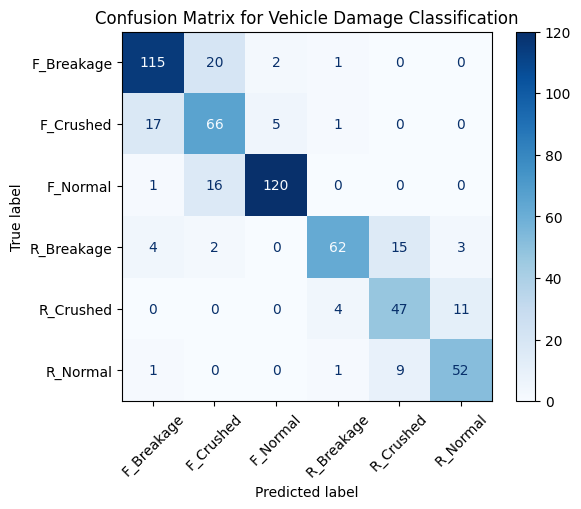

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [89]:
torch.save(model.state_dict(), 'saved_model.pth')